# RE:从零开始的线性回归
## 生成数据集

In [3]:
import random
import torch

In [4]:
from d2l import torch as d2l

### 这块的数据是模拟的，核心思想是：通过已知的w,b,生成一个噪声e,这个e符合正态分布

In [11]:
def synthetic_data(w,b,num_examples): #@save
    X=torch.normal(0,1,(num_examples,len(w)))
    y=torch.matmul(X,w)+b
    y+=torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))

In [12]:
true_w = torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)

In [13]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([-2.3003,  2.3793]) 
label: tensor([-8.5090])


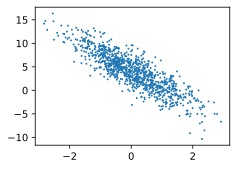

In [14]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1);

## 读取数据集

### 为实现抽取小批量样本，所以定义data_iter函数，用来实现打乱数据集样本并以小批量方式获取数据

In [20]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices=list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices=torch.tensor(
            indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]

In [21]:
batch_size=10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[-2.0305,  1.0319],
        [-0.0321,  0.2307],
        [-0.0774,  0.9792],
        [-0.0494, -0.5839],
        [-1.1752,  1.3316],
        [-0.1211, -0.6350],
        [ 0.7081,  0.7495],
        [-0.3203,  0.4112],
        [-2.1954,  0.3360],
        [ 1.1266, -0.0799]]) 
 tensor([[-3.3637],
        [ 3.3641],
        [ 0.7255],
        [ 6.0959],
        [-2.6865],
        [ 6.1149],
        [ 3.0729],
        [ 2.1725],
        [-1.3434],
        [ 6.7401]])


## 初始化参数

In [22]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

## 定义模型

In [23]:
def linreg(X,w,b): #@save
    return torch.matmul(X,w)+b

## 定义损失函数

In [24]:
def squared_loss(y_hat,y): #@save
    return (y_hat-y.reshape(y_hat.shape)) ** 2/2

## 定义优化算法

In [25]:
def sgd(params,lr,batch_size): #@save
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()

## 训练

In [26]:
lr =0.03 #学习率，超参数
num_epochs = 3
net = linreg
loss = squared_loss

In [27]:
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')

epoch1,loss0.047698
epoch2,loss0.000197
epoch3,loss0.000050


In [31]:
w.reshape(true_w.shape)

tensor([ 2.0001, -3.3988], grad_fn=<ReshapeAliasBackward0>)

In [32]:
b

tensor([4.1998], requires_grad=True)

# 使用现代化API实现

In [33]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [34]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = d2l.synthetic_data(true_w,true_b,1000)

In [41]:
def load_array(data_arrays,batch_size,is_train=True): #@save
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

In [42]:
batch_size=10
data_iter=load_array((features,labels),batch_size)

In [43]:
from torch import nn
net = nn.Sequential(nn.Linear(2,1))
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [44]:
loss = nn.MSELoss()

In [45]:
trainer = torch.optim.SGD(net.parameters(),lr=0.03)

In [46]:
num_epochs = 3
for epoch in range(num_epochs):
    for X,y in data_iter:
        l = loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features),labels)
    print(f'epochs{epoch + 1} , loss {l:f}')

epochs1 , loss 0.000183
epochs2 , loss 0.000093
epochs3 , loss 0.000092


In [47]:
w=net[0].weight.data

In [48]:
w

tensor([[ 1.9999, -3.3997]])

In [49]:
b=net[0].bias.data

In [50]:
b

tensor([4.1993])